In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I0000 00:00:1695921929.577543  119472 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=6.0
)

def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

/var/tmp/ipykernel_119472/279847780.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


In [6]:
b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


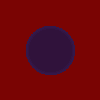

In [7]:
pose = b.transform_from_pos(jnp.array([0.0, 0.0, 0.3]))
img = b.RENDERER.render(pose[None,...], jnp.array([0]))

point_cloud = b.unproject_depth_jit(img[:,:,2], intrinsics)
point_cloud_not_far = point_cloud[point_cloud[:,:,2] < intrinsics.far, :]

b.get_depth_image(img[:,:,2])

In [8]:
means3D = torch.from_numpy(np.array(point_cloud_not_far)).float().to(device)
colors = means3D[:,2:3].repeat(1,3)


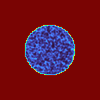

In [54]:
means3D = torch.from_numpy(np.array(point_cloud_not_far)).float().to(device)
colors = means3D[:,2:3].repeat(1,3)
N = means3D.shape[0]
means2D = torch.ones((N, 3),device= device)
opacity = torch.rand((N, 1)).cuda() + 0.5
scales = torch.rand((N, 3)).cuda() * 0.0001
rotations = torch.rand((N, 4)).cuda()

fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([intrinsics.far, intrinsics.far, intrinsics.far]).cuda(),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4).cuda(),
    projmatrix=proj_matrix,
    sh_degree=1,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)

rasterizer = GaussianRasterizer(raster_settings=raster_settings)


ground_truth_image, radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    shs = None,
    colors_precomp = colors,
    opacities = opacity,
    scales = scales,
    rotations = rotations,
    cov3D_precomp = None
)
# img_data = b.load_image_from_file("mustard.jpeg")
# print(np.array(img_data).shape)
# ground_truth_image = torch.tensor(np.moveaxis(np.array(img_data) / 255.0,-1,0),device=device)
# plt.imshow(np.moveaxis(ground_truth_image.cpu().numpy(),0,-1))
ground_truth_image_depth = np.moveaxis(ground_truth_image.cpu().numpy(),0,-1)[...,2]
b.get_depth_image(ground_truth_image_depth)

In [60]:
means3D = means3D.repeat(50,1)
# means3D = torch.tensor(
#     torch.rand((1000, 3),requires_grad=True).cuda() - 0.5 + torch.tensor([0.0, 0.0, 1.0],requires_grad=True,device= device)
#     ,device=device
#     ,requires_grad=True
# )
N = means3D.shape[0]
means2D = torch.zeros((N, 3),requires_grad=True, device=device)
opacity = torch.rand((N, 1),requires_grad=True,device=device)
scales = torch.tensor( 0.05 * torch.rand((N, 3)),requires_grad=True,device=device)
rotations = torch.rand((N, 4),requires_grad=True,device=device)

optimizer = torch.optim.Adam([means3D, colors, opacity, scales, rotations ], lr=0.001, eps=1e-15)
images = []

pbar = tqdm(range(1000))
for _ in pbar:
    rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = means3D[:,2:3].repeat(1,3),
        opacities = torch.sigmoid(opacity),
        scales = scales,
        rotations = rotations,
        cov3D_precomp = None
    )
    loss = ((rendered_image - ground_truth_image)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    images.append(rendered_image)
    pbar.set_description(f"{loss.item()}")
    # print(opacity.min(), opacity.max())


/var/tmp/ipykernel_119472/2981772398.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.05 * torch.rand((N, 3)),requires_grad=True,device=device)
25.373733520507812:   0%|          | 0/1000 [00:00<?, ?it/s]

0.3226490914821625: 100%|██████████| 1000/1000 [00:24<00:00, 41.66it/s]


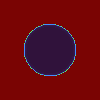

In [61]:
rendered_image_depth = np.moveaxis(images[200].detach().cpu().numpy(),0,-1)[...,2]
b.get_depth_image(rendered_image_depth)

In [62]:
b.clear()


In [63]:
b.show_cloud("rendered", b.unproject_depth_jit(np.moveaxis(images[990].detach().cpu().numpy(),0,-1)[...,2], intrinsics).reshape(-1,3),color=b.RED)


In [64]:
b.show_cloud("means", means3D.detach().cpu().numpy(),color=b.BLUE)

In [ ]:
b.show_cloud("observed", b.unproject_depth_jit(ground_truth_image_depth, intrinsics).reshape(-1,3))

In [31]:
rendered_image_depth

array([[6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       ...,
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.],
       [6., 6., 6., ..., 6., 6., 6.]], dtype=float32)

In [16]:
colors.max()

tensor(1.8980, device='cuda:0', grad_fn=<MaxBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


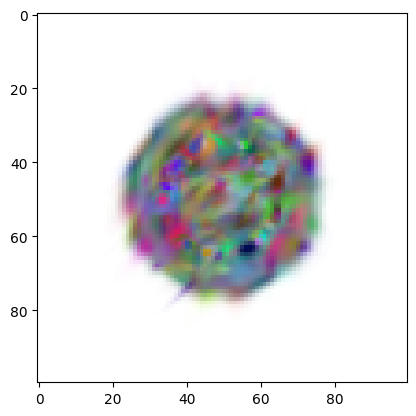

In [14]:
plt.imshow(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1))

In [19]:

import time
time.time()
dirname = os.path.join("/tmp/", f"{time.time()}")
os.mkdir(dirname)
img = b.get_rgb_image(np.moveaxis(ground_truth_image.cpu().numpy(),0,-1) * 255.0)
viz_images = [
    b.hstack_images(
        [
            b.get_rgb_image(np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1),max=1.0),
            img
        ]
    )
    for rendered_image in images
]


In [20]:
b.make_gif_from_pil_images(viz_images[::10], "optim.gif")

In [19]:
len(viz_images[::10])

100

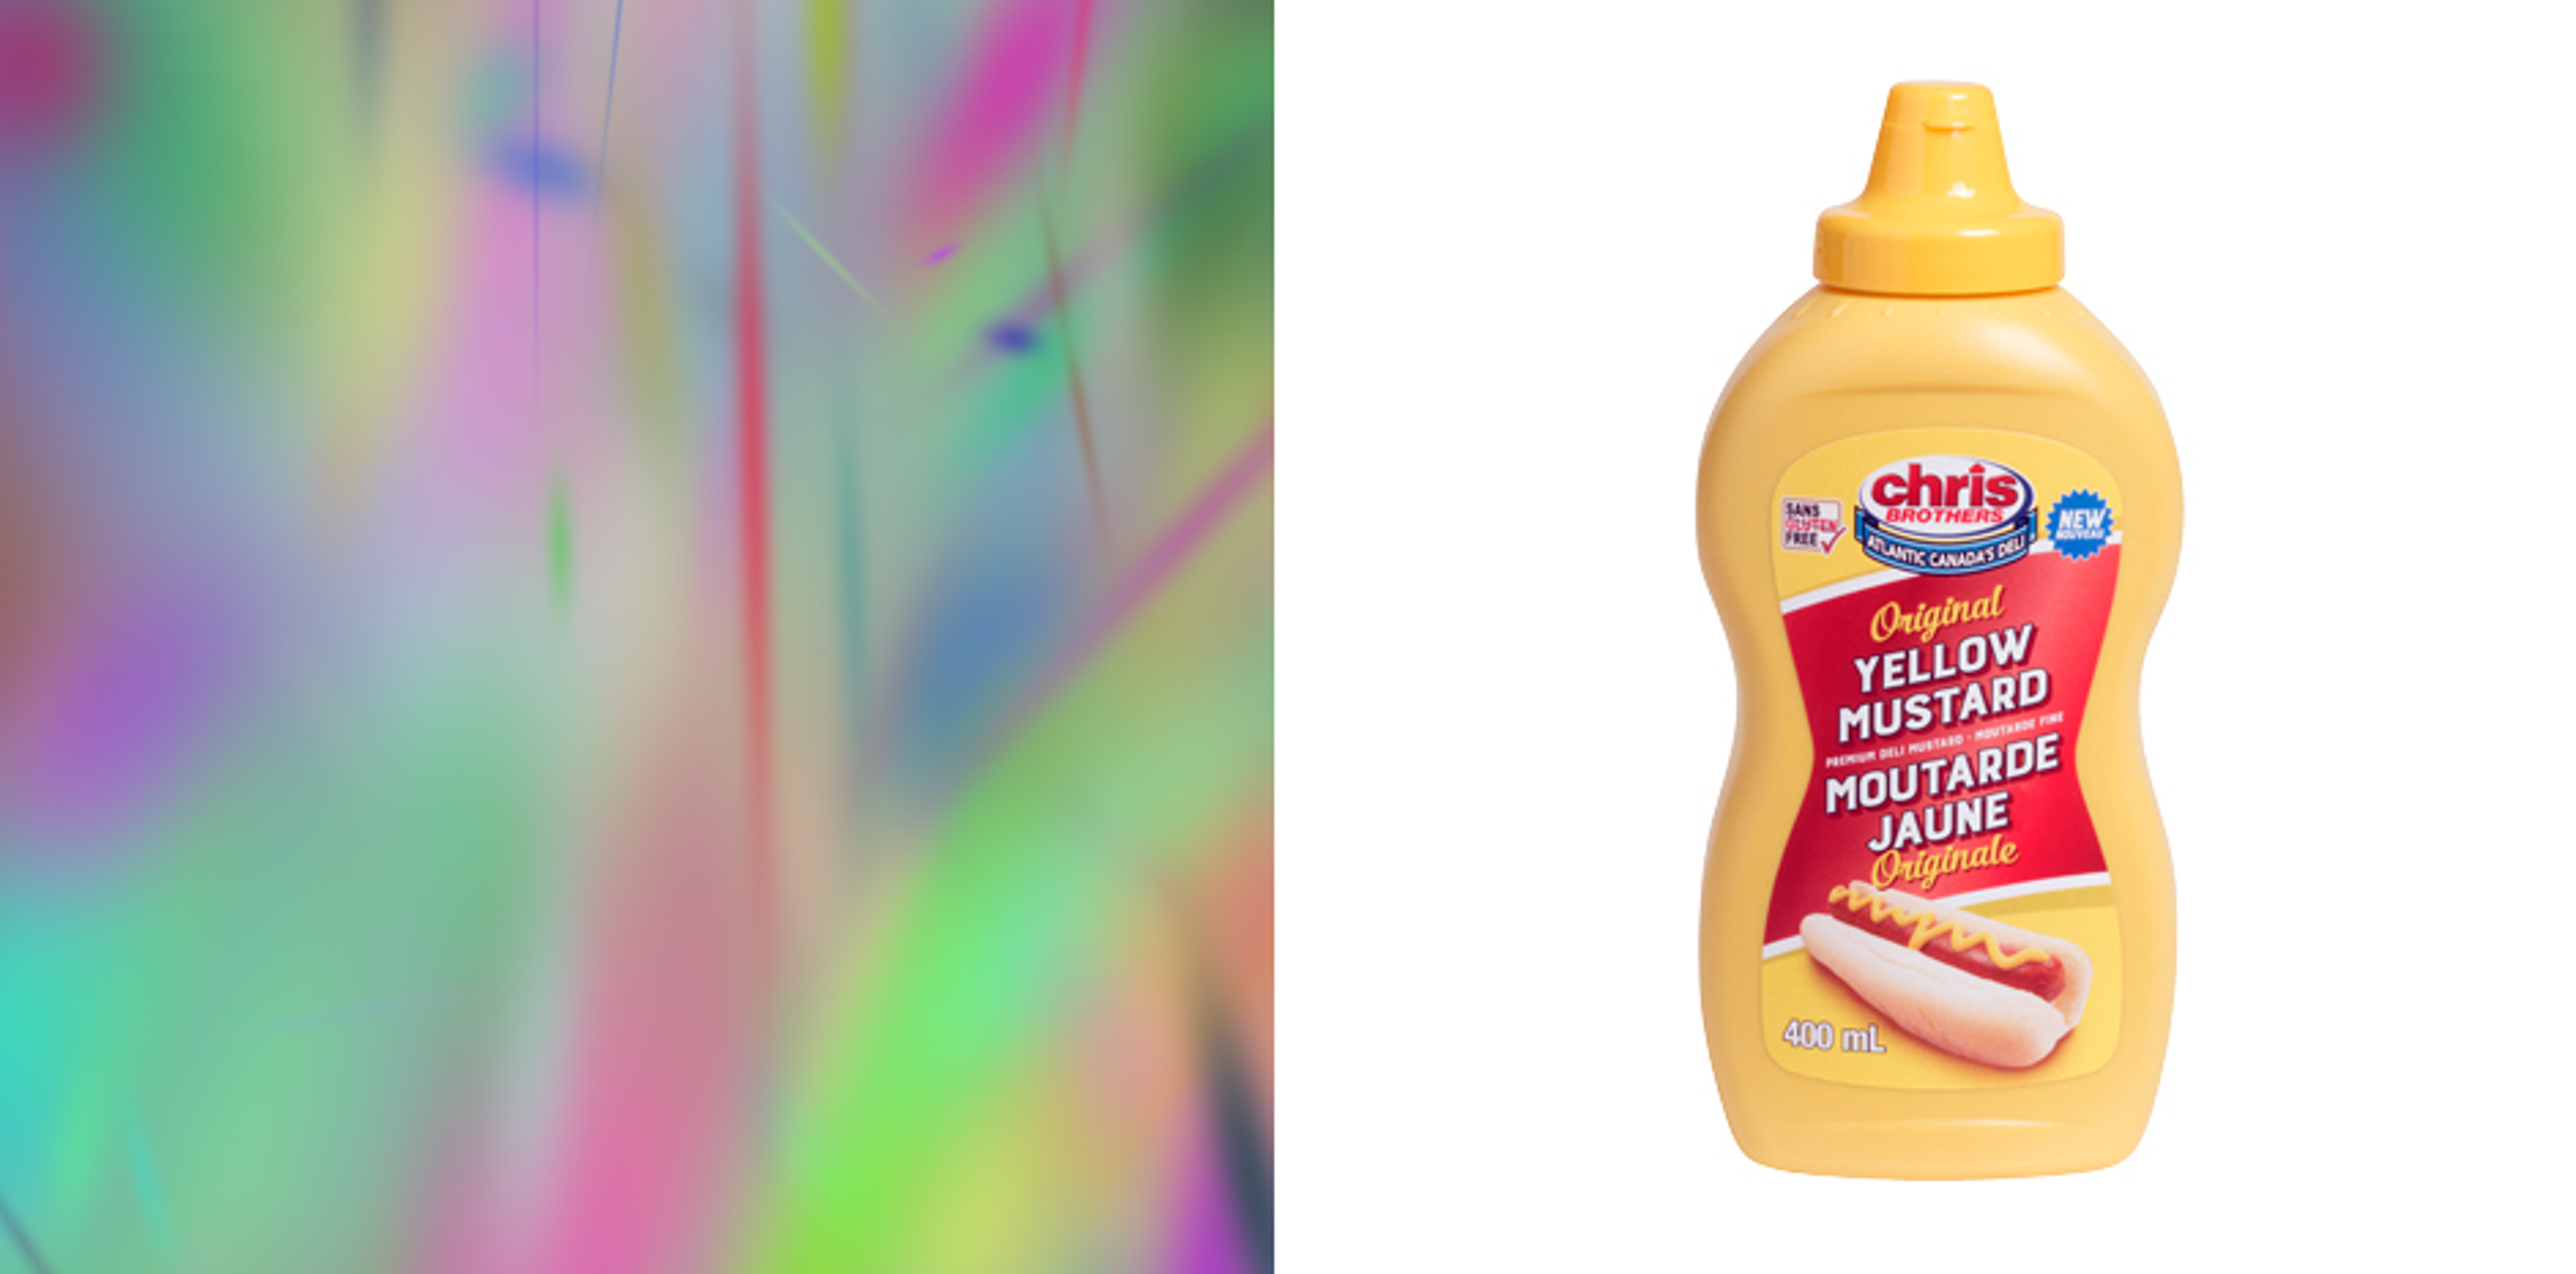

In [16]:
b.viz.scale_image(viz_images[-1],5)

In [95]:
for i,image in tqdm(enumerate(viz_images)):
    image.save(os.path.join(dirname, f"{i:05d}.png"))

1000it [02:05,  7.96it/s]


In [98]:
dirname

'/tmp/1695740504.1568244'

In [99]:
!ffmpeg -framerate 10 -i /tmp/1695740504.1568244/%05d.png -c:v libx264 -crf 0 output3.mp4

ffmpeg version 4.3.6-0+deb11u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

In [63]:
import cv2
video = cv2.VideoWriter("test2.avi", cv2.VideoWriter_fourcc('p', 'n', 'g', ' '), 24, (210,100))
for image in viz_images:
    video.write((np.array(image).astype(np.uint8)))
video.release()